## TOC:
* [Unzip data](#first-bullet)
* [Swath Selection](#second-bullet)
* [Calibration and save](#third-bullet)
* [Geolocation](#fourth-bullet)

In [1]:
import zipfile
import os
import numpy as np
import re
import xml.etree.ElementTree as etree
import rasterio
from rasterio.enums import Resampling
from natsort import natsorted
import imageio
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io
import copy
from pathlib import Path
from spectral import *

## Unzip data <a class="anchor" id="first-bullet"></a>

In [2]:
#Zip Data Path
path='/hdd/Sentinel_1_Git/Test/'
#Swath Selection,example 001
swath='021'

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

zipList= natural_sort([file for file in os.listdir(path) if file.endswith('.zip')])
print('Zip List')
print(np.array(zipList).T)

for file in zipList:   # get the list of files # if it is a zipfile, extract it
    if os.path.isdir(path+'SAFE/'+file[0:-4]+'.SAFE')==0:
        print("Doing ",file)
        with zipfile.ZipFile(path+file) as item: # treat the file as a zip
            item.extractall(path+'SAFE/')  # extract it in the working directory
    else:
        print(file,"already done")
    
print('Ended')


Zip List
['S1B_WV_SLC__1SSV_20210708T224514_20210708T225349_027709_034E8A_C0D8.zip'
 'S1B_WV_SLC__1SSV_20210720T224515_20210720T225350_027884_0353C2_1A7B.zip']
S1B_WV_SLC__1SSV_20210708T224514_20210708T225349_027709_034E8A_C0D8.zip already done
S1B_WV_SLC__1SSV_20210720T224515_20210720T225350_027884_0353C2_1A7B.zip already done
Ended


## Swath selection<a class="anchor" id="second-bullet"></a>

In [3]:
safeList= natural_sort([file for file in os.listdir(path+'SAFE/') if file.endswith('.SAFE')])
slcList=[]

for file in safeList:   # get the list of files in the folder
    tiffVignette=[tifile for tifile in os.listdir(path+'SAFE/'+file+'/measurement/') if tifile.endswith(swath +'.tiff')]# get the list of tiff files in the measurement folder
    for slc in tiffVignette:
        slcList.append(str(file) + '/measurement/' + str(slc))

print(np.array(slcList).T)
print('Ended')

['S1B_WV_SLC__1SSV_20210708T224514_20210708T225349_027709_034E8A_C0D8.SAFE/measurement/s1b-wv1-slc-vv-20210708t225007-20210708t225010-027709-034e8a-021.tiff'
 'S1B_WV_SLC__1SSV_20210720T224515_20210720T225350_027884_0353C2_1A7B.SAFE/measurement/s1b-wv1-slc-vv-20210720t225008-20210720t225011-027884-0353c2-021.tiff']
Ended


## Calibration and save <a class="anchor" id="third-bullet"></a>

SLC number 0
S1B_WV_SLC__1SSV_20210708T224514_20210708T225349_027709_034E8A_C0D8.SAFE/measurement/s1b-wv1-slc-vv-20210708t225007-20210708t225010-027709-034e8a-021.tiff
S1B_WV_SLC__1SSV_20210708T224514_20210708T225349_027709_034E8A_C0D8.SAFE/annotation/calibration/calibration-s1b-wv1-slc-vv-20210708t225007-20210708t225010-027709-034e8a-021.xml


/home/npaillou/anaconda3/envs/WV/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


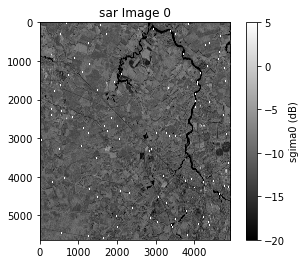

SLC number 1
S1B_WV_SLC__1SSV_20210720T224515_20210720T225350_027884_0353C2_1A7B.SAFE/measurement/s1b-wv1-slc-vv-20210720t225008-20210720t225011-027884-0353c2-021.tiff
S1B_WV_SLC__1SSV_20210720T224515_20210720T225350_027884_0353C2_1A7B.SAFE/annotation/calibration/calibration-s1b-wv1-slc-vv-20210720t225008-20210720t225011-027884-0353c2-021.xml


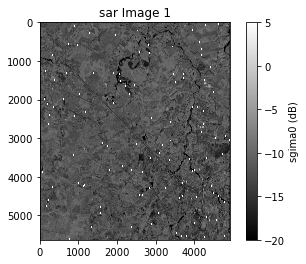

Ended


In [4]:
slcList=natsorted(slcList)
calibList=copy.deepcopy(slcList);
for n in range(0,len(slcList)):
    calibList[n]='calibration-'+slcList[n]
    calibList[n]=slcList[n].replace('measurement/','annotation/calibration/calibration-')
    calibList[n]=calibList[n].replace('.tiff','.xml')
    print('SLC number '+str(n))
    print(slcList[n])
    print(calibList[n])
    fp1 = path+'SAFE/' + slcList[n]
    img1 = rasterio.open(fp1)
    sarImage=(img1.read(1)).T

    RasterWidth=img1.width
    RasterHeight=img1.height
    
    with open(path+'SAFE/'+calibList[n], 'r') as xml_file:
        xml_tree = etree.parse(xml_file)
    root=xml_tree.getroot()

    # READ Pixel 
    PixelArray=[]
    for child in root.findall('calibrationVectorList'):
        for calibVec in child.findall('calibrationVector'):
            for pixel in (calibVec.findall('pixel')):
                (PixelArray.append((pixel.text).split()))
    PixelArray=np.array(PixelArray)  

    # READ sigmaNought
    sigmaNoughtArray=[]
    for child in root.findall('calibrationVectorList'):
        for calibVec in child.findall('calibrationVector'):
            for pixel in (calibVec.findall('sigmaNought')):
                (sigmaNoughtArray.append(((pixel.text).split())))
    sigmaNoughtArray=np.float32(np.array(sigmaNoughtArray))     
    
    # SAVE CALIB ARRAYS AS TIF (This part has to be checked)

    upscale_factorx=(RasterWidth)/(sigmaNoughtArray.shape[0]) # scaling in x (targetNumberPixel/LowResPixel)
    upscale_factory=(RasterHeight)/(sigmaNoughtArray.shape[1])  # scaling in y (targetNumberPixel/LowResPixel)
    Path(path+"SigmaNought").mkdir(parents=True, exist_ok=True)
    imageio.imwrite(path+'SigmaNought/sigmaNoughtArray_' + str (n) +'.tif', sigmaNoughtArray)

    # RESAMPLE
    
    with rasterio.open(path+'SigmaNought/sigmaNoughtArray_' + str (n) +'.tif') as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factorx),
                int(dataset.width * upscale_factory)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )

    sigmaNoughtArrayResampled=(data)
    lut_calibration=sigmaNoughtArrayResampled[0,:,:]
    np.argwhere(np.isnan(sarImage))
    
    
    # CALIBRATE AND SAVE
    Path(path+"Result").mkdir(parents=True, exist_ok=True)
    sarImage[abs(sarImage)==0]='nan'
    sigma0=np.abs(sarImage)/lut_calibration
    mdic = {"sarImage": sarImage}
    scipy.io.savemat(path+'Result/sarImage_' + str(n) + '.mat', mdic)
    mdic = {"sigma0": sigma0}
    scipy.io.savemat(path+'Result/sigma0_' + str(n) + '.mat', mdic)
    fig = plt.figure()
    plt.imshow((20*np.log10(sigma0)), cmap='gray')
    cbar=plt.colorbar()
    cbar.set_label('sgima0 (dB)')
    plt.title('sar Image ' + str(n))
    plt.clim(-20,5)
    plt.show()
    
print('Ended')

## Geolocation (to be checked using .kmz)<a class="anchor" id="fourth-bullet"></a>

In [5]:
gptpath='/home/npaillou/snap/bin/gpt'
Latxmlpath='/hdd/Sentinel_1_Git/Lat.xml'
Longxmlpath='/hdd/Sentinel_1_Git/Long.xml'
n=0
print(safeList)
for file in safeList:
    
    print(file)
    ##Create a temporary copy
    newfile=file[0:-5]+'_REARRANGED.SAFE'
    Copycommand='cp -R '+path+'SAFE/'+file+' '+path+'SAFE/'+newfile
    os.system(Copycommand)
    
    ##Change names in measurement
    firstname=path+'SAFE/'+newfile+'/measurement/'+natural_sort([tifile for tifile in os.listdir(path+'SAFE/'+newfile+'/measurement/') if tifile.endswith('.tiff')])[0]
    swathname=path+'SAFE/'+newfile+'/measurement/'+[tifile for tifile in os.listdir(path+'SAFE/'+newfile+'/measurement/') if tifile.endswith(swath +'.tiff')][0]
    tmpname='temporal.tiff'
    cmd='mv '+firstname+' '+tmpname
    os.system(cmd)
    cmd='mv '+swathname+' '+firstname
    os.system(cmd)
    cmd='mv '+tmpname+' '+swathname
    os.system(cmd)
    
    ##Change names in annotation
    firstname=path+'SAFE/'+newfile+'/annotation/'+natural_sort([tifile for tifile in os.listdir(path+'SAFE/'+newfile+'/annotation/') if tifile.endswith('.xml')])[0]
    swathname=path+'SAFE/'+newfile+'/annotation/'+[tifile for tifile in os.listdir(path+'SAFE/'+newfile+'/annotation/') if tifile.endswith(swath +'.xml')][0]
    tmpname='temporal.tiff'
    cmd='mv '+firstname+' '+tmpname
    os.system(cmd)
    cmd='mv '+swathname+' '+firstname
    os.system(cmd)
    cmd='mv '+tmpname+' '+swathname
    os.system(cmd)
    
    ##Change names in annotation/calibration
    firstname=path+'SAFE/'+newfile+'/annotation/calibration/'+natural_sort([tifile for tifile in os.listdir(path+'SAFE/'+newfile+'/annotation/calibration/') if tifile.endswith('.xml')])[0]
    swathname=path+'SAFE/'+newfile+'/annotation/calibration/'+[tifile for tifile in os.listdir(path+'SAFE/'+newfile+'/annotation/calibration/') if tifile.endswith(swath +'.xml')][0]
    tmpname='temporal.tiff'
    cmd='mv '+firstname+' '+tmpname
    os.system(cmd)
    cmd='mv '+swathname+' '+firstname
    os.system(cmd)
    cmd='mv '+tmpname+' '+swathname
    os.system(cmd)
    
    inputdatapath=path+'SAFE/'+newfile+'/manifest.safe'
    outputdataLat=inputdatapath[0:-14]+'_Lat.dim'
    outputdataLong=inputdatapath[0:-14]+'_Long.dim'
    Latcommand=gptpath+' '+Latxmlpath+' -Pinput1='+inputdatapath+' -Poutput1='+outputdataLat+' >/dev/null 2>&1'
    Longcommand=gptpath+' '+Longxmlpath+' -Pinput1='+inputdatapath+' -Poutput1='+outputdataLong+' >/dev/null 2>&1'
    os.system(Latcommand)
    os.system(Longcommand)
    
    img = envi.open(outputdataLat[0:-4]+'.data/'+'LatitudeMatrix.hdr') 
    img_open = img.open_memmap(writeable = True)
    latitude = img_open[:,:,0] 
    latitude=np.transpose(latitude)
    mdic = {"latitude": latitude}
    scipy.io.savemat(path+'Result/latitude' + str(n) + '.mat', mdic)
    
    img = envi.open(outputdataLong[0:-4]+'.data/'+'LongitudeMatrix.hdr') 
    img_open = img.open_memmap(writeable = True) 
    longitude = img_open[:,:,0] 
    longitude=np.transpose(longitude)
    mdic = {"longitude": longitude}
    scipy.io.savemat(path+'Result/longitude' + str(n) + '.mat', mdic)
    
    cmd='rm -r '+path+'SAFE/'+newfile
    os.system(cmd)
    cmd='rm -r '+outputdataLat
    os.system(cmd)
    cmd='rm -r '+outputdataLat[0:-4]+'.data'
    os.system(cmd)
    cmd='rm -r '+outputdataLong
    os.system(cmd)
    cmd='rm -r '+outputdataLong[0:-4]+'.data'
    os.system(cmd)
    n=n+1
    
print('Ended')

['S1B_WV_SLC__1SSV_20210708T224514_20210708T225349_027709_034E8A_C0D8.SAFE', 'S1B_WV_SLC__1SSV_20210720T224515_20210720T225350_027884_0353C2_1A7B.SAFE']
S1B_WV_SLC__1SSV_20210708T224514_20210708T225349_027709_034E8A_C0D8.SAFE
S1B_WV_SLC__1SSV_20210720T224515_20210720T225350_027884_0353C2_1A7B.SAFE
Ended
